In [2]:

!pip install keras-tuner --upgrade



  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl.metadata (221 bytes)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)


In [7]:

!pip install --upgrade tensorflow==2.14.0


  Using cached tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.14.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.14.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.14.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
Using cached tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (489.8 MB)
Using cached keras-2.14.0-py3-none-any.whl (1.7 MB)
Using cached tensorboard-2.14.1-py3-none-any.whl (5.5 MB)
Using cached tensorflow_estimator-2.14.0-py2.py3-none-any.whl (440 kB)
Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
   

In [1]:

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import multilabel_confusion_matrix
from shutil import copyfile
import zipfile
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import matplotlib.pyplot as plt
%matplotlib inline


2024-04-08 23:30:50.788637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 23:30:50.788699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 23:30:50.788734: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 23:30:50.798892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 23:30:51.840571: W tensorflow/compiler/

In [2]:

os.getcwd()


'/home/ec2-user/SageMaker'

In [3]:

import tensorflow as tf
print(tf.__version__)


2.14.0


In [4]:

# List all available physical devices
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

# Specifically check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f"GPU is available: {gpus}")
else:
    print("GPU is not available.")


Available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


2024-04-08 23:31:04.368559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 23:31:04.368983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-08 23:31:04.369344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats-and-dogs.zip"

local_zip = '/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/home/ec2-user/SageMaker/Convolutional Neural Net_TF')
zip_ref.close()


--2024-04-08 23:32:50--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.222.202.7, 2600:1408:ec00:889::317f, 2600:1408:ec00:88e::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.222.202.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats-and-dogs.zip’

100%[======================================>] 824,887,076  195MB/s   in 4.3s   

2024-04-08 23:32:54 (183 MB/s) - ‘/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats-and-dogs.zip’ saved [824887076/824887076]



In [8]:

source_path = '/home/ec2-user/SageMaker/Convolutional Neural Net_TF/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find '/home/ec2-user/SageMaker/Convolutional Neural Net_TF/PetImages/' -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")


There are 12501 images of dogs.
There are 12500 images of cats.


In [9]:

# Define root directory
root_dir = '/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
    os.makedirs(os.path.join(root_path, 'training'))
    os.makedirs(os.path.join(f'{root_path}/training', 'dogs'))
    os.makedirs(os.path.join(f'{root_path}/training', 'cats'))
    os.makedirs(os.path.join(root_path, 'testing'))
    os.makedirs(os.path.join(f'{root_path}/testing', 'dogs'))
    os.makedirs(os.path.join(f'{root_path}/testing', 'cats')) 

try:
    create_train_val_dirs(root_path=root_dir)
except FileExistsError:
    print("You should not be seeing this since the upper directory is removed beforehand")


In [10]:

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))


/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split/testing
/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split/training
/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split/testing/dogs
/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split/testing/cats
/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split/training/dogs
/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split/training/cats


In [11]:

len(os.listdir("/home/ec2-user/SageMaker/Convolutional Neural Net_TF/PetImages/Cat"))


12500

In [12]:

len(os.listdir("/home/ec2-user/SageMaker/Convolutional Neural Net_TF/PetImages/Dog"))


12501

In [39]:

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, valid_split_size, test_split_size):
    
    shuffled_source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))
    # training_number = int(len(shuffled_source) * SPLIT_SIZE)
    testing_number = test_split_size
    validation_number = valid_split_size
    i = 0

    target = TESTING_DIR

    for item in shuffled_source:
        item_source = os.path.join(SOURCE_DIR, item)
        if os.path.isfile(item_source):
            if os.path.getsize(item_source) == 0:
                print(f'{item} is zero length, so ignoring.')
            else:
                copyfile(item_source, os.path.join(target, item))
                i += 1

        if i == testing_number:
            target = VALIDATION_DIR

        elif i == validation_number:
            target = TRAINING_DIR



In [38]:

# def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, valid_split_size, test_split_size):
#     files = []
#     for filename in os.listdir(SOURCE_DIR):
#         file = SOURCE_DIR + filename
#         if os.path.getsize(file) > 0:
#             files.append(filename)
#         else:
#             print(filename + " is zero length, so ignoring.")

#     testing_size = int(len(files) * test_split_size)
#     validation_size = int(len(files) * valid_split_size)
#     training_size = len(files) - testing_size - validation_size

#     shuffled_set = random.sample(files, len(files))
#     training_set = shuffled_set[testing_size+validation_size:]
#     validation_set = shuffled_set[testing_size:testing_size+validation_size]
#     testing_set = shuffled_set[:testing_size]

#     for filename in training_set:
#         this_file = SOURCE_DIR + filename
#         destination = TRAINING_DIR + filename
#         copyfile(this_file, destination)

#     for filename in validation_set:
#         this_file = SOURCE_DIR + filename
#         destination = VALIDATION_DIR + filename
#         copyfile(this_file, destination)

#     for filename in testing_set:
#         this_file = SOURCE_DIR + filename
#         destination = TESTING_DIR + filename
#         copyfile(this_file, destination)


In [40]:


# Define paths
CAT_SOURCE_DIR = "/home/ec2-user/SageMaker/Convolutional Neural Net_TF/PetImages/Cat/"
DOG_SOURCE_DIR = "/home/ec2-user/SageMaker/Convolutional Neural Net_TF/PetImages/Dog/"

TRAINING_DIR = "/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split/training/"
VALIDATION_DIR = "/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split/validation/"
TESTING_DIR = "/home/ec2-user/SageMaker/Convolutional Neural Net_TF/cats_dogs_data_split/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
    for file in os.scandir(TRAINING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
    for file in os.scandir(TRAINING_DOGS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
    for file in os.scandir(VALIDATION_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
    for file in os.scandir(VALIDATION_DOGS_DIR):
        os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
    for file in os.scandir(TESTING_CATS_DIR):
        os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
    for file in os.scandir(TESTING_DOGS_DIR):
        os.remove(file.path)

valid_split_size = 1200
test_split_size = 250
# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, TESTING_CATS_DIR, valid_split_size, test_split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, TESTING_DOGS_DIR, valid_split_size, test_split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12501 images

There are 11299 images of cats for training
There are 11299 images of dogs for training
There are 950 images of cats for validation
There are 950 images of dogs for validation
There are 250 images of cats for testing
There are 250 images of dogs for testing


In [43]:

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    # train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.09)
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR, 
                                                        batch_size=128, class_mode='binary', target_size=(150, 150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR, 
                                                                  batch_size=32, class_mode='binary', target_size=(150, 150))
    
    return train_generator, validation_generator

def model_build():
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00016),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

#How to set up a CV loop for a computer vision problem?

def model_training(EPOCHS):
    import datetime
    start_time = datetime.datetime.now()
    train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)
    callbacks = myCallback()
    model = model_build()
    history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, verbose=2, callbacks=[callbacks])
    end_time = datetime.datetime.now()
    print("Training time: ", end_time - start_time)
    return history


In [ ]:

history = model_training(10)


Found 22598 images belonging to 3 classes.
Found 1900 images belonging to 3 classes.


2024-04-09 00:29:04.491891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 00:29:04.492305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 00:29:04.492655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/10


2024-04-09 00:29:10.055788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


177/177 - 192s - loss: -9.0572e+05 - accuracy: 0.4977 - val_loss: -4.1898e+06 - val_accuracy: 0.5000 - 192s/epoch - 1s/step
Epoch 2/10
177/177 - 143s - loss: -2.3030e+07 - accuracy: 0.5000 - val_loss: -5.9120e+07 - val_accuracy: 0.5000 - 143s/epoch - 810ms/step
Epoch 3/10
177/177 - 144s - loss: -1.5668e+08 - accuracy: 0.5000 - val_loss: -3.0756e+08 - val_accuracy: 0.5000 - 144s/epoch - 812ms/step
Epoch 4/10
177/177 - 143s - loss: -4.2203e+09 - accuracy: 0.5000 - val_loss: -6.0862e+09 - val_accuracy: 0.5000 - 143s/epoch - 810ms/step
Epoch 7/10
177/177 - 143s - loss: -8.8256e+09 - accuracy: 0.5000 - val_loss: -1.2110e+10 - val_accuracy: 0.5000 - 143s/epoch - 809ms/step
Epoch 8/10
177/177 - 144s - loss: -1.6663e+10 - accuracy: 0.5000 - val_loss: -2.2101e+10 - val_accuracy: 0.5000 - 144s/epoch - 812ms/step
Epoch 9/10
177/177 - 144s - loss: -2.9334e+10 - accuracy: 0.5000 - val_loss: -3.7772e+10 - val_accuracy: 0.5000 - 144s/epoch - 812ms/step
Epoch 10/10
177/177 - 144s - loss: -4.8747e+10 -

In [45]:

def plot_learning_curve_metric(history, lower_limit, upper_limit):
    plt.plot(history['accuracy'], label='training_accuracy')
    plt.plot(history['val_accuracy'], label='validation_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='lower right')

def plot_learning_curve_loss(history, lower_limit, upper_limit):
    plt.plot(history['loss'], label='training_loss')
    plt.plot(history['val_loss'], label='validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.ylim([lower_limit, upper_limit])
    plt.legend(loc='upper right')
    plt.show()



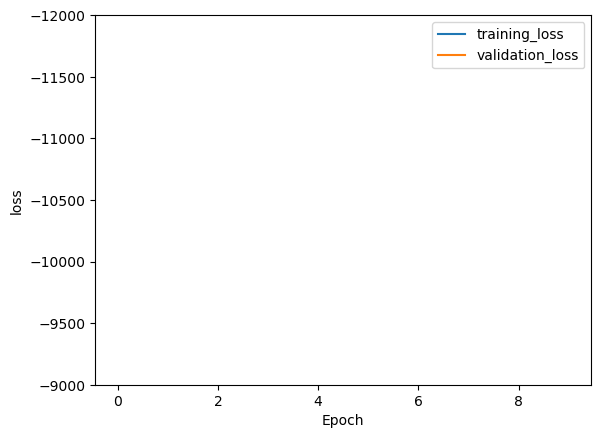

In [54]:

plot_learning_curve_loss(history.history, -9000, -12000)


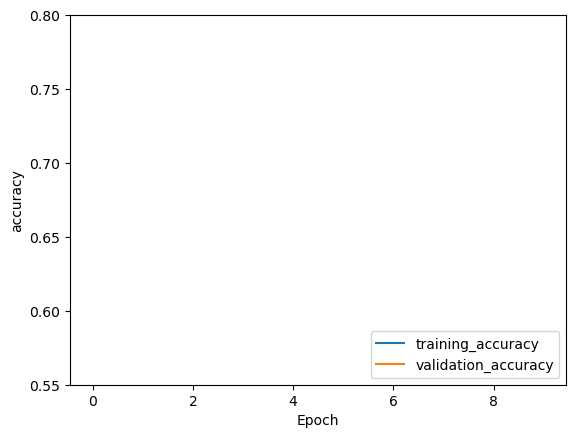

In [55]:

plot_learning_curve_metric(history.history, 00, 0)
